In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    "/storage/vbutoi/scratch/ESE/training/09_25_24_ISLES_3D_Dice_HeavyAug",
]

df_list_1 = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list_1.append(df)
    except Exception as e:
        print(e)

df = pd.concat(df_list_1)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# # Subselect the df to only include lr that == 1.e-04
# df = df[df['lr'] == 1.e-04]

In [4]:
df['lr'].unique()

array([1.e-05])

In [5]:
def exp_name(path):
    return str(path).split("/")[-2]

df.augment(exp_name)

In [6]:
# we need to make batch_size and lr cateogorical variables
df['batch_size'] = df['batch_size'].astype('category')
df['lr'] = df['lr'].astype('category')

In [7]:
for ikey in df.columns:
    print(ikey)

phase
epoch
loss
abs_area_estimation_error
area_estimation_error
dice_score
ece_loss
affine_probability
max_rotation
max_scaling
max_translation
warp_integrations
warp_magnitude_range
warp_probability
warp_smoothing_range
added_noise_max_sigma
added_noise_probability
bias_field_probability
gamma_scaling_max
gamma_scaling_probability
use_mask
data
in_channels
out_channels
preload
return_data_id
train_splits
val_splits
version
batch_size
num_workers
pin_memory
seed
torch_compile
torch_mixed_precision
loss_func
batch_reduction
from_logits
model
convs_per_block
dims
filters
optim
lr
epochs
eval_freq
path
exp_name


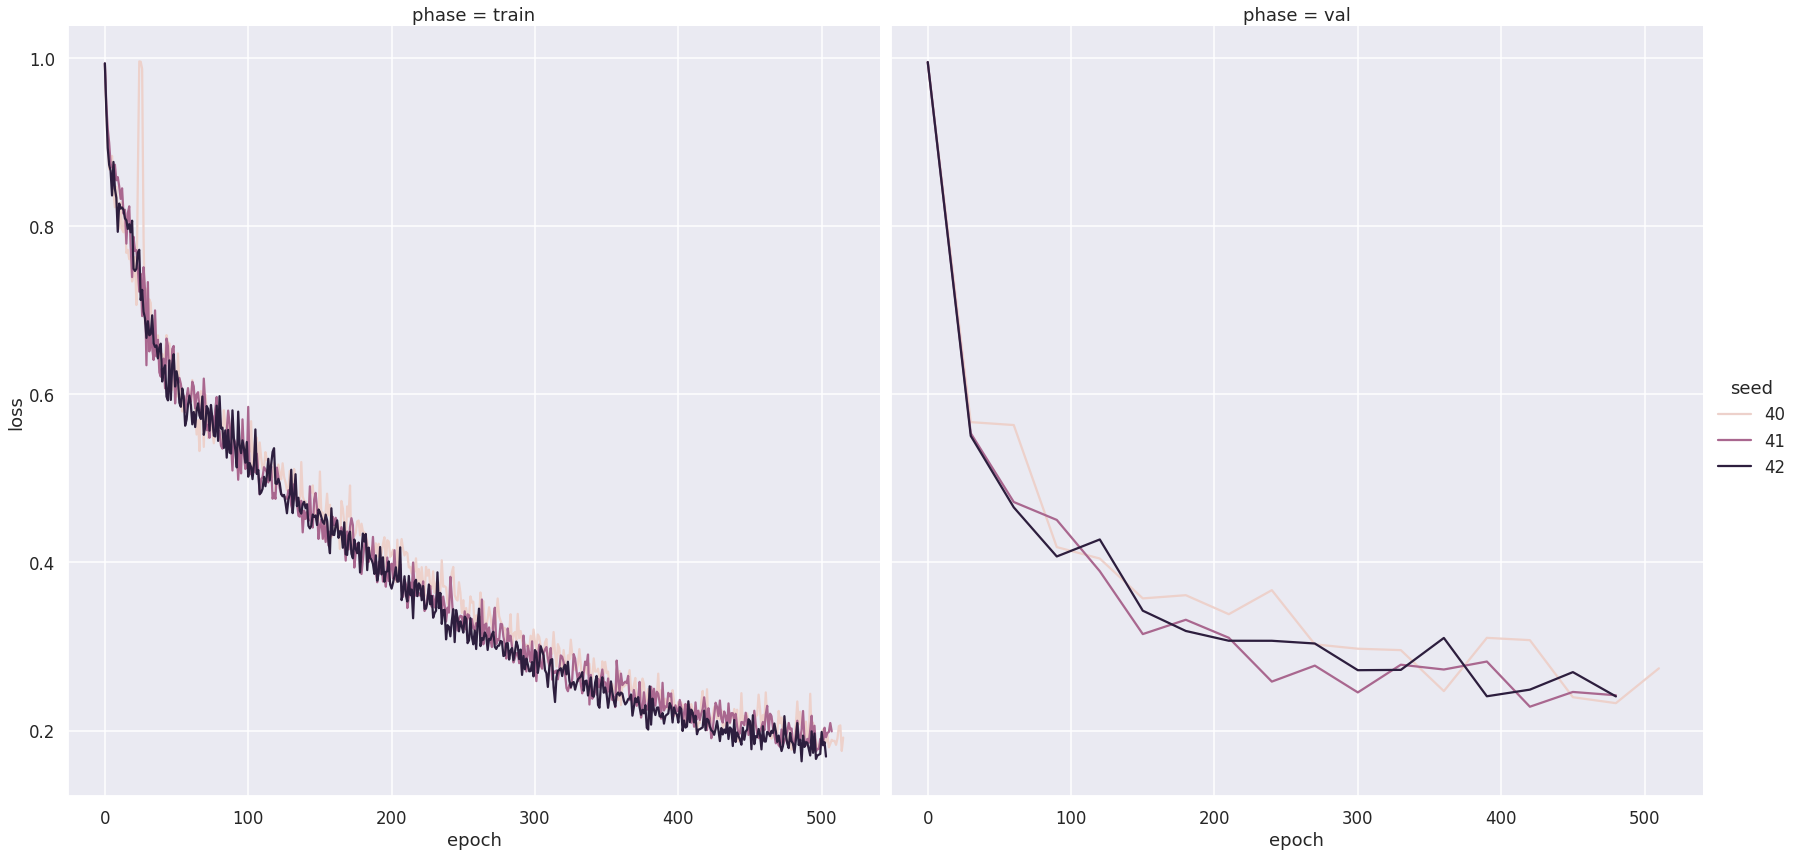

In [8]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='seed',
    # hue='exp_name',
    col='phase',
    kind='line',
    height=12,
    # facet_kws=dict(sharey=False),
)

# Set column spacing
# g.fig.subplots_adjust(wspace=0.12)
# g.set(ylim=(0, 10))

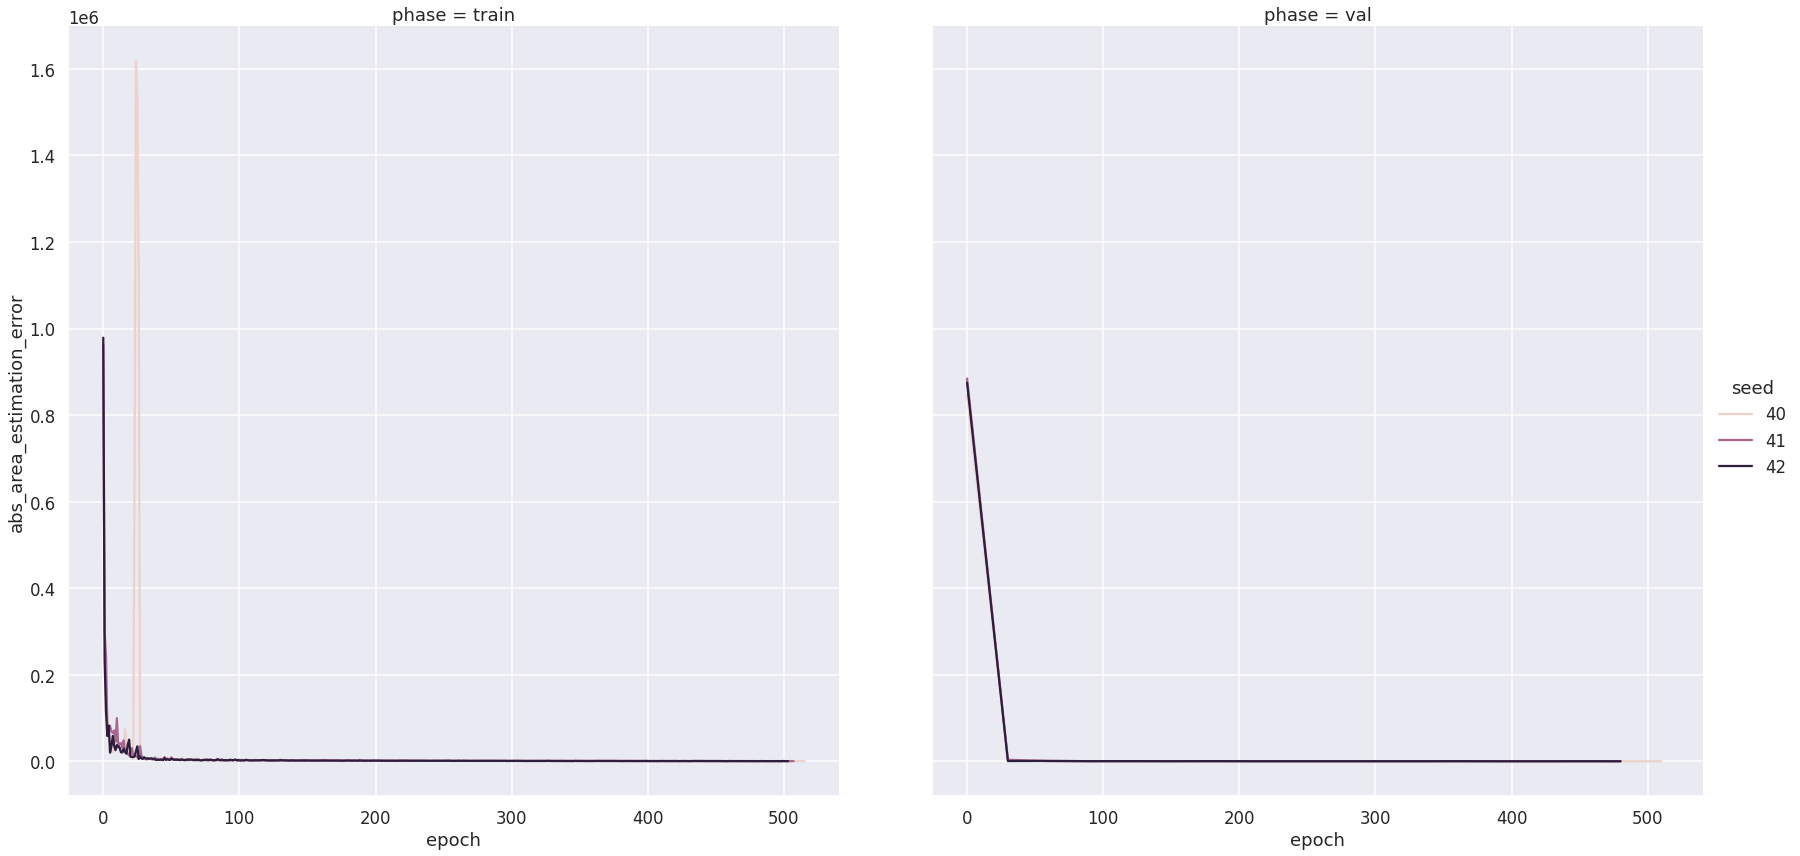

In [9]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='abs_area_estimation_error',
    hue='seed',
    # hue='exp_name',
    col='phase',
    kind='line',
    height=12,
    # facet_kws=dict(sharey=False),
)

# Set column spacig
g.fig.subplots_adjust(wspace=0.12)
# g.set(ylim=(0.0, 0.25))

In [10]:
# g =  sns.relplot(
#     data=df,
#     x='epoch',
#     y='dice_score',
#     # hue='seed',
#     hue='exp_name',
#     col='phase',
#     kind='line',
#     height=12,
#     facet_kws=dict(sharey=False),
# )

# # Set column spacig
# g.fig.subplots_adjust(wspace=0.12)
# # g.set(ylim=(0.0, 0.25))